In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm
import cvxpy as cp
from systems_and_functions.control_affine_system import ControlAffineSystem
# from systems_and_functions.cart_pole_system import CartPole
from systems_and_functions.inverted_pendulum_system import InvertedPendulum
from systems_and_functions.single_track_car_system import SingleTrackCar
from systems_and_functions.networks import PolicyNet, LyapunovNet, DFunctionNet

%matplotlib notebook 
%matplotlib inline  

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [2]:
# Varifying Almost Lyapunov Conditions
"""
1. Compute the derivative of Lyapnuov Candidate dV/dx
2. Using ture dunamics f = dx/dt
3. Judge the sign of dV/dt
"""

# # # Lyapunov of dlearning_ip
# actor = torch.load('experiment_results/Dlearning/ip_PI1500_lr2_satuation_40iter_converg0.1/model/actor_model.pth')
# lyapunov = torch.load('experiment_results/Dlearning/ip_PI1500_lr2_satuation_40iter_converg0.1/model/lyapunov_model.pth')

# Lyapunov of dopt_ip
actor = torch.load('experiment_results/DOPT/ip_PI1500_lr2_tau0.3_satuation_40iter/model/target_actor_model.pth')
lyapunov = torch.load('experiment_results/DOPT/ip_PI1500_lr2_tau0.3_satuation_40iter/model/target_lyapunov_model.pth')

params={'m': 1.5,'L': 1.0, 'b': 0.5}
controller_params = {'K':np.array([[15,  4]])}
p1 = InvertedPendulum(system_params = params,
                      controller_params = controller_params,
                      dt = 0.01, 
                      controller_period = 0.01)

x = np.linspace(-4, 4, 30)
y = np.linspace(-12, 12, 30)
X, Y = np.meshgrid(x, y)
Z_d = np.zeros(X.shape)
Z_l = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xy = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32).to(device)
        V, _ = lyapunov.V_with_JV(xy)
        # JV = JV[0]
        Z_l[i, j] = V.item()
        # u = actor.Controller(xy)
        # print('u',u)
        # print('JV',JV.shape)
        # print('xy',xy.shape)
        # print('p1.x_dot(xy, u)',p1.x_dot(xy.t(), u).shape)
        # print((JV @ p1.x_dot(xy.t(), u)).shape)
        # if (JV @ p1.x_dot(xy.t(), u)).item() > 0:
        #     Z_d[i, j] = 1
        # else:
        #     Z_d[i, j] = None

positive_xy_coordinates = []
negative_xy_coordinates = []

sample_number_in_radius = 40000
sample_radius_random = 10
theta_ = np.random.uniform(0, 2*np.pi, sample_number_in_radius)
r_ = np.sqrt(np.random.uniform(0, sample_radius_random**2, sample_number_in_radius))
combined_data = zip(theta_, r_)
for data in combined_data:
    theta__, r__ = data
    xy = torch.tensor([[r__ * np.cos(theta__)],[r__ * np.sin(theta__)]], dtype=torch.float32).to(device)
    _, JV = lyapunov.V_with_JV(xy.t())
    JV = JV[0]
    u = actor.Controller(xy)
    if (JV @ p1.x_dot(xy, u)).item() > 0:
        Z_d[i, j] = JV @ p1.x_dot(xy, u)
        positive_xy_coordinates.append(xy.cpu().numpy())
    else:
        Z_d[i, j] = JV @ p1.x_dot(xy, u)
        negative_xy_coordinates.append(xy.cpu().numpy())


Controller is involved.


C:\Users\28451\AppData\Local\Temp\ipykernel_22340\1985421632.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(X, Y, Z_l, levels=[0.496], colors='purple', linewidths=1.5,label='estimated RoA') # dlearning


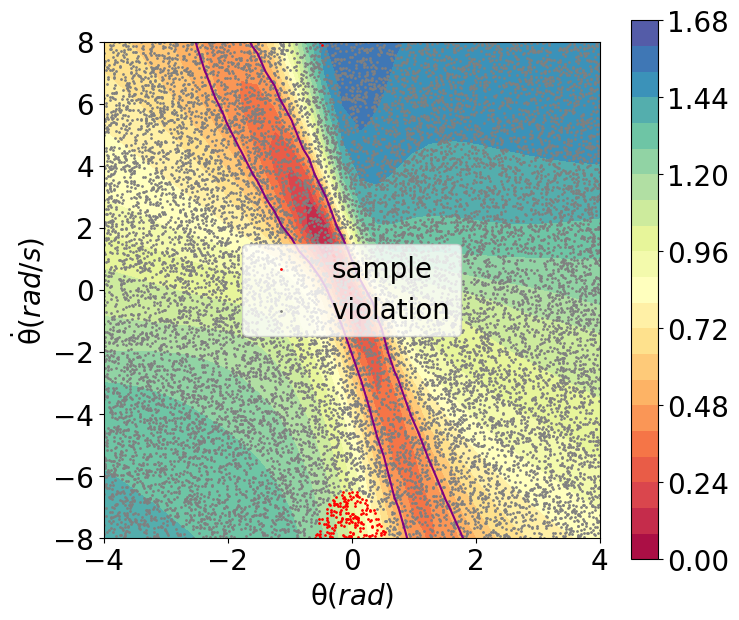

In [6]:
fig, ax = plt.subplots(figsize=(8, 7))
# cp_d = ax.contourf(X, Y, Z_l, levels=25, cmap='RdBu')
cp_d = ax.contourf(X, Y, Z_l, levels=25, cmap='Spectral')
ax.scatter(*zip(*positive_xy_coordinates), s = 1, color='r',label='sample')
ax.scatter(*zip(*negative_xy_coordinates), s = 1, color='grey',label='violation') 
ax.contour(X, Y, Z_l, levels=[0.496], colors='purple', linewidths=1.5,label='estimated RoA') # dlearning
# ax.contour(X, Y, Z_l, levels=[0.791], colors='purple', linewidths=1.5) # dopt
fig.colorbar(cp_d, ax=ax)
ax.legend()
ax.set_aspect(0.5)
ax.set_xlim([-4, 4])
ax.set_ylim([-8, 8])
# ax.set_title('Verifying Almost Lyapunov Conditions')
ax.set_xlabel(r"$\mathregular{\theta}(rad)$")
ax.set_ylabel(r"$\mathregular{\dot{\theta}}(rad/s)$")

ax.set_xlabel(r"$\mathregular{\theta}(rad)$")
ax.set_ylabel(r"$\mathregular{\dot{\theta}}(rad/s)$")
fig.savefig('almostlyapunovcondition_nodots_ip1.png',dpi=1200)
plt.show()

In [ ]:
# Varifying Almost Lyapunov Conditions
"""
1. Compute the derivative of Lyapnuov Candidate dV/dx
2. Using ture dunamics f = dx/dt
3. Judge the sign of dV/dt
"""

system_params = {'psi_ref': 0.5, 'v_ref': 1, 'a_ref': 0.0, 'omega_ref': 0.0, 'mu_scale': 0.1}

car1 = SingleTrackCar(
    system_params = system_params,
    controller_params = None,
    dt = 0.01,
    controller_period = 0.01)

# Lyapunov of dlearning_stc
# actor = torch.load('experiment_results/Dlearning/stc_PI300_lr2/model/actor_model.pth')
# lyapunov = torch.load('experiment_results/Dlearning/stc_PI300_lr2/model/lyapunov_model.pth')


# Lyapunov of dopt_stc
actor = torch.load('experiment_results/DOPT/stc_20iter/model/target_actor_model.pth')
lyapunov = torch.load('experiment_results/DOPT/stc_20iter/model/target_lyapunov_model.pth')

positive_xy_coordinates = []
negative_xy_coordinates = []

x = np.linspace(-2.5, 2.5, 100)
y = np.linspace(-2.5, 2.5, 100)
X, Y = np.meshgrid(x, y)
Z_d = np.zeros(X.shape)
Z_l = np.zeros(X.shape)
random_seed = 4
torch.manual_seed(random_seed)
others = torch.rand(1,7-2).to(device)*0.5


for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        xy = torch.tensor([[X[i, j], Y[i, j]]], dtype=torch.float32).to(device)
        xy1 = torch.cat((xy, others), dim=1).to(device)
        Z_l[i, j] = lyapunov.V(xy1).item()

sample_number_in_radius = 20000
sample_radius_random = 4
theta_ = np.random.uniform(0, 2*np.pi, sample_number_in_radius)
r_ = np.sqrt(np.random.uniform(0, sample_radius_random**2, sample_number_in_radius))
combined_data = zip(theta_, r_)
for data in combined_data:
    theta__, r__ = data
    xy = torch.tensor([[r__ * np.cos(theta__)],[r__ * np.sin(theta__)]], dtype=torch.float32).to(device)
    xy1 = torch.cat((xy.t(), others), dim=1).to(device)
    _, JV = lyapunov.V_with_JV(xy1)
    JV = JV[0]
    u = actor.Controller(xy1).t()
    if (JV @ car1.x_dot(xy1, u).t()).item() >= 0:
        Z_d[i, j] = JV @ car1.x_dot(xy1, u).t()
        positive_xy_coordinates.append(xy.cpu().numpy())
    else:
        Z_d[i, j] = JV @ car1.x_dot(xy1, u).t()
        negative_xy_coordinates.append(xy.cpu().numpy())


In [ ]:
fig, ax = plt.subplots(figsize=(8, 7))
cp_d = ax.contourf(X, Y, Z_l, levels=20, cmap='RdBu', alpha = 1)

fig.colorbar(cp_d, ax=ax)
if len(positive_xy_coordinates)!=0:
    ax.scatter(*zip(*positive_xy_coordinates), s = 1, color='red')
if len(negative_xy_coordinates)!=0:
    ax.scatter(*zip(*negative_xy_coordinates), s = 1, color='grey')
# ax.contour(X, Y, Z_l, levels=[0.158], colors='purple', linewidths=1.5)
ax.contour(X, Y, Z_l, levels=[0.20], colors='purple', linewidths=1.5)
ax.set_xlabel(r"$\mathregular{x_{err}}(m)$")
ax.set_ylabel(r"$\mathregular{y_{err}}(m)$")
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_aspect("equal")
# fig.savefig('almostlyapunovcondition_stc1.png',dpi=1200)
plt.show()